In [4]:
# Builds basic transmission screens for nulling

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
# define the aperture

# Parameters for the grid and circles
N = 200  # size of the image, e.g., 200x200
radius = 10  # radius of each circle, in pixels
d = 70       # distance from center to the center of each circle (in pixels)
pixel_scale = 0.01  # meters per pixel

# Create grid coordinates (x and y)
x = np.arange(N) - N // 2
y = np.arange(N) - N // 2
X, Y = np.meshgrid(x, y)

# Two circles, equidistant from center along the x-axis
circle1 = ((X - d/2)**2 + Y**2) < radius**2
circle2 = ((X + d/2)**2 + Y**2) < radius**2

# First slice: binary mask of the two circles (OR them together)
aperture = np.zeros((N, N), dtype=float)
aperture[(circle1 | circle2)] = 1

# Slices 2 and 3: x and y coordinates in meters
x_m = (X) * pixel_scale
y_m = (Y) * pixel_scale

# Make the 3D array
aperture_cube = np.zeros((3, N, N), dtype=float)
aperture_cube[0] = aperture
aperture_cube[1] = x_m
aperture_cube[2] = y_m


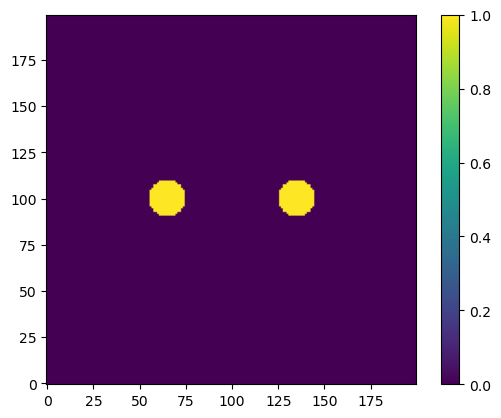

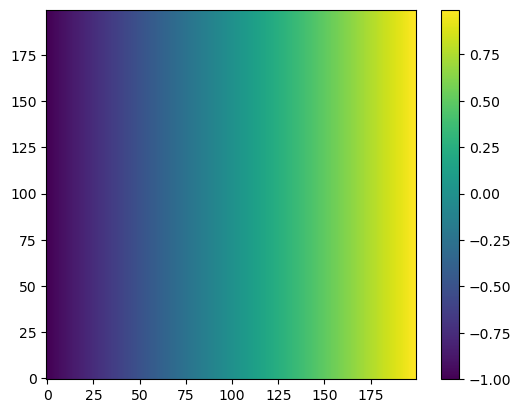

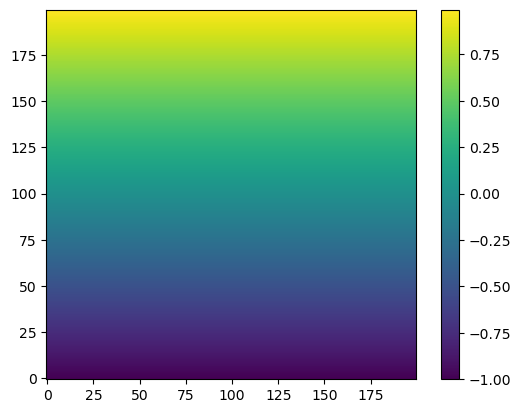

In [8]:
plt.imshow(aperture_cube[0], origin='lower')
plt.colorbar()
plt.show()

plt.imshow(aperture_cube[1], origin='lower')
plt.colorbar()
plt.show()

plt.imshow(aperture_cube[2], origin='lower')
plt.colorbar()
plt.show()


In [33]:
# define the astrophysical scene

pixel_scale_onsky = 0.01  # arcseconds per pixel

astro_cube = np.zeros((3, N, N), dtype=float)
astro_scene = np.zeros((N, N), dtype=float)

# Make an "image" where only one pixel is illuminated (value 1), all others are 0
# Choose an off-center position, e.g., (row 130, col 80)
row, col = 130, 80
astro_scene[row:row+4, col:col+4] = 1

# Create on-sky grid coordinates (x and y) in arcseconds
x = np.arange(N) - N // 2
y = np.arange(N) - N // 2
X, Y = np.meshgrid(x, y)

# Slices 2 and 3: x and y coordinates in meters
x_asec = (X) * pixel_scale_onsky
y_asec = (Y) * pixel_scale_onsky

# add the coordinates
astro_cube[0] = astro_scene
astro_cube[1] = y_asec
astro_cube[2] = x_asec

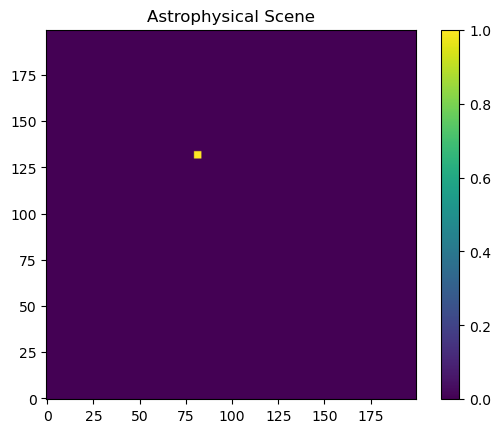

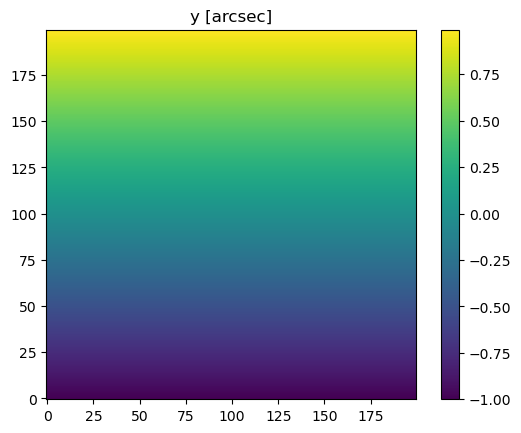

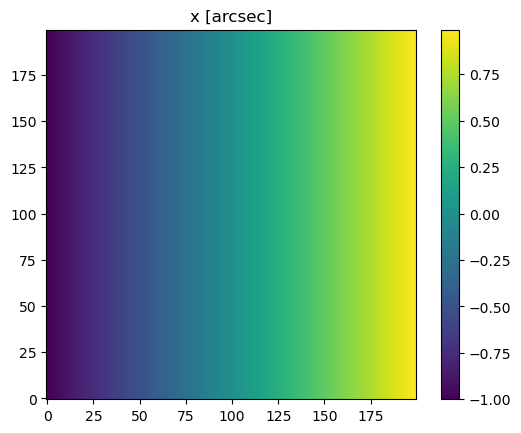

In [35]:
# plot astrophysical scene
plt.imshow(astro_cube[0], origin='lower')
plt.title('Astrophysical Scene')
plt.colorbar()
plt.show()

plt.imshow(astro_cube[1], origin='lower')
plt.title('y [arcsec]')
plt.colorbar()
plt.show()

plt.imshow(astro_cube[2], origin='lower')
plt.title('x [arcsec]')
plt.colorbar()
plt.show()

# apply the transmission screens to the astrophysical scene


In [26]:
# interferometer response as fcn of sky position (Dannert+ 2025 Eqn. B12, ignoring polarization for now)

A_vec = np.array([1, 1]) # array of amplitudes
x_vec = np.array(([0, -1], [0, 1])) # array of vectors of aperture positions (y,x) [m]
phi_dc_vec_rad = np.array([0, np.pi/4]) # array of absolute DC (i.e., induced) phase offsets of each branch of the instrument [rad]
theta_vec_asec = np.array([0, 4]) # position of something on the sky (y_asec, x_asec) [arcsec]
wavel_m = 1e-6 # wavelength in meters

In [ ]:

#del_phi_dc_jk = phi_dc_vec[0] - phi_dc_vec[1] # differential phase between two branches
#del_x_jk = x_vec[0] - x_vec[1] # baseline from one aperture to another
#print(np.dot(del_x_jk, theta_vec))

-3.141592653589793


In [97]:
def old_R_theta_vec(A_vec, x_vec, phi_dc_vec_rad, theta_vec_2d_asec, wavel_m):
    # theta_vec_rad: cube with slice 0 = y_asec, slice 1 = x_asec

    del_phi_dc_jk_rad = phi_dc_vec_rad[1] - phi_dc_vec_rad[0] # differential phase between two branches [rad]

    print('del_phi_dc_jk_rad')
    print(del_phi_dc_jk_rad)

    print('theta_vec_2d_asec')
    print(theta_vec_2d_asec)
    theta_vec_rad_array = np.divide(theta_vec_2d_asec, 206265) # convert to rad

    del_x_jk = x_vec[1] - x_vec[0] # baseline from one aperture to another [m]

    # initialize the instrument response array 
    R_theta_vec = np.zeros(np.shape(theta_vec_2d_asec[0]))

    # for each sky position, compute the instrument response
    print(np.shape(R_theta_vec))
    print('ha')
    #print(R_theta_vec.shape)
    for i in range(0,np.shape(R_theta_vec)[1]): # y
        for j in range(0,np.shape(R_theta_vec)[0]): # x
            print('--------------------------------')
            print(i)
            print(j)

            theta_vec_rad_this = np.array([theta_vec_rad_array[0,j,i], theta_vec_rad_array[1,j,i]])

            R_theta_vec[j,i] = A_vec[0] * A_vec[1] * ( np.cos(del_phi_dc_jk_rad) * np.cos( (2*np.pi / wavel_m) * np.dot( del_x_jk, theta_vec_rad_this ) ) - np.sin(del_phi_dc_jk_rad) * np.sin( (2*np.pi / wavel_m) * np.dot( del_x_jk, theta_vec_rad_this ) ) ) # np.dot() units are m

    return R_theta_vec

In [118]:
def R_theta_vec(A_vec, x_vec, phi_dc_vec_rad, theta_vec_2d_asec, wavel_m, incl_comp_transmission=False):
    # instrument respose over the sky

    '''
    INPUTS:
    A_vec: array of amplitudes
    x_vec: array of vectors of aperture positions (y,x) [m]
    phi_dc_vec_rad: array of absolute DC (i.e., induced) phase offsets of each branch of the instrument [rad]
    theta_vec_2d_asec: cube with slice 0 = y_asec, slice 1 = x_asec
    wavel_m: wavelength in meters
    incl_comp_transmission: boolean, if True, include the transmissions of the component baselines in slice 1 to -3

    OUTPUT:
    R_theta_vec: instrument response over the sky; slices are
      [0] = total instrument response
      [1:-3] = instrument responses of the component baselines
      [-2] = y coord in sky [arcsec]
      [-1] = x coord in sky [arcsec]
    '''

    # theta_vec_rad: cube with slice 0 = y_asec, slice 1 = x_asec
    # Vectorized version that works for arbitrary number of apertures
    
    # Convert sky positions from arcsec to radians
    theta_vec_rad_array = np.divide(theta_vec_2d_asec, 206265)  # shape: (2, Ny, Nx)
    
    # Get number of apertures
    N_apertures = len(A_vec)
    
    # Initialize the instrument response array
    R_theta_vec = np.zeros(np.shape(theta_vec_2d_asec[0]))  # shape: (Ny, Nx)
    
    # Calculate total number of baselines (unique pairs of apertures)
    # For N apertures, number of unique baselines = N*(N-1)/2
    N_baselines = N_apertures * (N_apertures - 1) // 2
    print(f'Total number of baselines: {N_baselines}')

    #if incl_comp_transmission:
    #    cube_canvas = np.zeros((N_baselines+3, N, N))

    cube_canvas = np.zeros((3, N, N))

    # Sum over all pairs of apertures (j, k) where j < k
    for j in range(N_apertures):
        for k in range(j + 1, N_apertures):

            # Differential phase between apertures j and k [rad]
            del_phi_dc_jk_rad = phi_dc_vec_rad[k] - phi_dc_vec_rad[j]
            
            # Baseline from aperture j to aperture k [m]
            del_x_jk = x_vec[k] - x_vec[j]  # shape: (2,)
            
            # Compute phase term for all sky positions at once using broadcasting
            # theta_vec_rad_array has shape (2, Ny, Nx), del_x_jk has shape (2,)
            # We want to compute dot(del_x_jk, theta_vec_rad_array) for all positions
            # This gives shape (Ny, Nx)
            phase_term = (2 * np.pi / wavel_m) * (
                del_x_jk[0] * theta_vec_rad_array[0] +  # y component
                del_x_jk[1] * theta_vec_rad_array[1]    # x component
            )
            
            # Use cosine addition formula: cos(a + b) = cos(a)cos(b) - sin(a)sin(b)
            # This is more efficient than computing cos and sin separately
            response_jk = A_vec[j] * A_vec[k] * np.cos(del_phi_dc_jk_rad + phase_term)
            
            # Add contribution from this pair to the total response
            '''
            plt.clf()
            plt.imshow(response_jk)
            plt.colorbar()
            plt.show()

            # if incl_comp_transmission, add this as a separate slice
            if incl_comp_transmission:
            '''

            # Add contribution from this pair to the total response
            R_theta_vec += response_jk

    # cube_canvas[0,:,:] = R_theta_vec
    cube_canvas[0,:,:] = R_theta_vec
    cube_canvas[1:,:,:] = theta_vec_rad_array[0,:,:] # y-coords [asec]
    cube_canvas[2:,:,:] = theta_vec_rad_array[1,:,:] # x-coords [asec]
    
    return cube_canvas

In [119]:
# test screen
A_vec = np.array([1, 1, 1])
x_vec = np.array(([0, -1], [0, 1], [1, 1]))
phi_dc_vec_rad = np.array([0, np.pi/4, 0])
test_new = R_theta_vec(A_vec=A_vec, x_vec=x_vec, phi_dc_vec_rad=phi_dc_vec_rad, theta_vec_2d_asec=astro_cube[1:,:,:], wavel_m=wavel_m)

Total number of baselines: 3


In [117]:
test_new.shape

(200, 200)

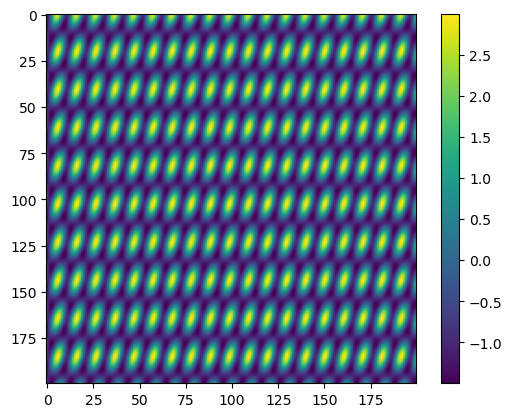

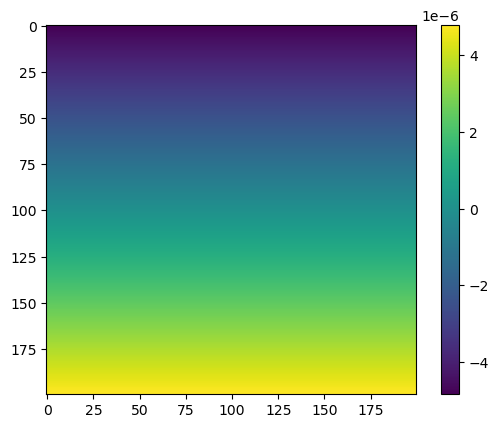

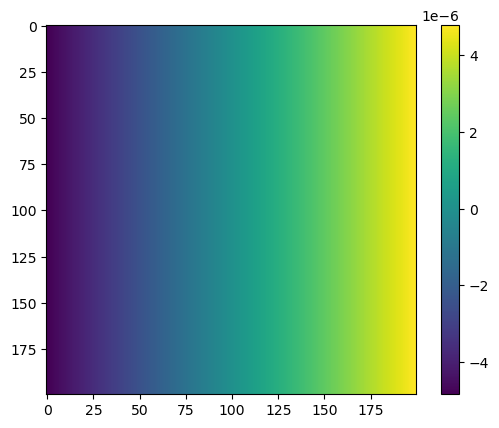

In [121]:

plt.imshow(test_new[0,:,:])
plt.colorbar()
plt.show()


plt.imshow(test_new[1,:,:])
plt.colorbar()
plt.show()


plt.imshow(test_new[2,:,:])
plt.colorbar()
plt.show()

In [ ]:
# total photon rate (Dannert 2025 Eqn. B19, ignoring polarization for now)



def n_tot(del_lambda, Aj, Ak, del_phi_jk, B_twiddle_sky_symm, B_twiddle_sky_asymm):

    n = del_lambda * Aj * Ak * ( np.cos(del_phi_jk) * B_twiddle_sky_symm - 1j * np.sin(del_phi_jk) * B_twiddle_sky_asymm )

    return n